In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amex-data-sampled/train_df_sample.pkl


### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">4강) TOAD 라이브러리를 활용한 신용평가 모델 개발</p>

> ### 데이터 준비

In [2]:
import warnings
warnings.filterwarnings('ignore', module='sklearn.metrics.cluster')

In [3]:
def drop_null_cols(df, threshold=0.8):
    """
    데이터프레임에서 결측치 비율이 threshold 이상인 변수를 제거하는 함수
    """
    null_percent = df.isnull().mean()
    drop_cols = list(null_percent[null_percent >= threshold].index)
    df = df.drop(drop_cols, axis=1)
    print(f"Dropped {len(drop_cols)} columns: {', '.join(drop_cols)}")
    return df

In [4]:
df = pd.read_pickle('/kaggle/input/amex-data-sampled/train_df_sample.pkl')
df = df.reset_index()

import hashlib

def encode_customer_id(id_str):
    encoded_id = hashlib.sha256(id_str.encode('utf-8')).hexdigest()[:16]
    return encoded_id

df['customer_ID'] = df['customer_ID'].apply(encode_customer_id)
df = drop_null_cols(df)

Dropped 106 columns: D_49_mean, D_49_std, D_49_min, D_49_max, D_49_last, D_73_mean, D_73_std, D_73_min, D_73_max, D_73_last, D_76_mean, D_76_std, D_76_min, D_76_max, D_76_last, R_9_mean, R_9_std, R_9_min, R_9_max, R_9_last, B_29_mean, B_29_std, B_29_min, B_29_max, B_29_last, D_87_mean, D_87_std, D_87_min, D_87_max, D_87_last, D_88_mean, D_88_std, D_88_min, D_88_max, D_88_last, D_106_mean, D_106_std, D_106_min, D_106_max, D_106_last, R_26_mean, R_26_std, R_26_min, R_26_max, R_26_last, D_108_mean, D_108_std, D_108_min, D_108_max, D_108_last, D_110_mean, D_110_std, D_110_min, D_110_max, D_110_last, D_111_mean, D_111_std, D_111_min, D_111_max, D_111_last, B_39_mean, B_39_std, B_39_min, B_39_max, B_39_last, B_42_mean, B_42_std, B_42_min, B_42_max, B_42_last, D_132_mean, D_132_std, D_132_min, D_132_max, D_132_last, D_134_mean, D_134_std, D_134_min, D_134_max, D_134_last, D_135_mean, D_135_std, D_135_min, D_135_max, D_135_last, D_136_mean, D_136_std, D_136_min, D_136_max, D_136_last, D_137_me

In [5]:
cat_features = [
    "B_30",
    "B_38",
    "D_114",
    "D_116",
    "D_117",
    "D_120",
    "D_126",
    "D_63",
    "D_64",
    "D_68"
]
cat_features = [f"{cf}_last" for cf in cat_features]

In [6]:
import random

num_cols = df.select_dtypes(include=np.number).columns.tolist()
num_cols = [col for col in num_cols if 'target' not in col and col not in cat_features]
num_cols_sample = random.sample([col for col in num_cols if 'target' not in col], 100)

In [7]:
feature_list = num_cols_sample + cat_features
all_list = feature_list + ['target']

In [8]:
df = df[all_list]

In [9]:
for categorical_feature in cat_features:
    if df[categorical_feature].dtype == 'float16':
        df[categorical_feature] = df[categorical_feature].astype(str)
    if df[categorical_feature].dtype == 'category':
        df[categorical_feature] = df[categorical_feature].astype(str)    
    elif df[categorical_feature].dtype == 'object':
        df[categorical_feature] = df[categorical_feature].astype(str)

In [10]:
from sklearn.preprocessing import LabelEncoder

le_encoder = LabelEncoder()

for categorical_feature in cat_features:
    df[categorical_feature].fillna(value='NaN', inplace=True)
    df[categorical_feature] = le_encoder.fit_transform(df[categorical_feature])

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
from sklearn.impute import SimpleImputer

def impute_nan(df, num_cols, strategy='mean'):
    """
    NaN 값을 strategy에 따라 num_cols에 대해 impute하는 함수
    
    :param df: DataFrame
    :param num_cols: list, imputation 대상 numeric column 리스트
    :param strategy: str, imputation 전략 (default: 'mean')
    :return: DataFrame, imputed DataFrame
    """
    imputer = SimpleImputer(strategy=strategy)
    df[num_cols] = imputer.fit_transform(df[num_cols])
    return df

In [12]:
df = impute_nan(df,num_cols_sample, strategy="mean")

> #### taod 패키지 설치

In [14]:
%pip install toad

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 25.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


> #### IV값을 기준으로 변수를 선택해보자. (Feature Selection) 

In [18]:
import toad

# 타겟 변수 정의
target = 'target'

# 정보값(IV) 계산 및 특성 선택
iv_df = toad.quality(df, target=target, iv_only=True)
selected_features = iv_df[iv_df['iv'] > 0.1].index  # 'name' 대신 'index'를 사용합니다.

# WOE 변환
trans = toad.transform.WOETransformer()
df_woe = trans.fit_transform(df[selected_features], df[target])

# 이제 df_woe를 추가적인 모델링에 사용할 수 있습니다.


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


toad는 파이썬의 데이터 전처리 및 탐색을 위한 오픈 소스 패키지입니다. 주요 기능은 다음과 같습니다:

데이터 품질 평가: toad.quality() 함수를 사용하여 변수별 정보값(IV, Information Value)을 계산하고, 타겟 변수와의 상관 관계를 평가합니다. 이를 통해 변수의 중요도를 판단하고 특성 선택에 활용할 수 있습니다.

데이터 변환: WOE (Weight of Evidence) 변환을 위한 toad.transform.WOETransformer()를 사용할 수 있습니다. WOE는 범주형 변수나 연속형 변수를 범주화하여 정보값을 측정하는 방법으로, 변수의 예측력을 개선하고 모델 성능을 향상시킬 수 있습니다.

In [19]:
df_woe

,B_7_last,D_61_last,D_61_mean,D_48_max,D_44_last,B_2_last,R_1_std,B_9_mean,B_38_last,D_74_last,...,D_118_min,B_24_last,D_117_last,B_32_mean,B_14_std,S_26_mean,D_50_std,D_72_min,R_21_last,R_25_mean
0,-0.343805,1.205008,0.719716,0.215811,0.386383,-0.056123,1.042489,1.042489,1.408741,-0.439115,...,0.349342,0.454702,0.192825,-0.056123,1.042489,0.669814,0.275565,0.637024,-0.615739,0.077408
1,-1.355406,1.330171,0.160100,0.717067,0.503493,1.581486,1.042489,-0.903421,0.394101,0.535241,...,-0.056123,-1.154735,-0.421929,-0.230477,1.042489,1.042489,1.042489,-0.210274,0.126198,-0.242023
2,-2.093005,-1.442418,-1.665561,-0.749270,-1.154735,-1.630838,0.324917,-0.749270,-1.277605,-2.093005,...,0.371257,-1.097577,0.371257,0.349342,0.324917,0.391902,0.275565,1.042489,0.086978,-0.229142
3,-1.442418,-1.730100,-1.596568,-0.423848,-1.226194,-1.710789,1.042489,-0.461588,-1.873590,-0.972414,...,0.012870,0.462671,-0.751712,-0.478538,1.042489,-0.566949,0.275565,0.674764,-0.972414,-0.021337
4,0.167020,-0.566949,-0.749270,-1.596568,-1.790724,-1.933454,1.042489,-0.749270,-1.873590,-0.343805,...,-1.308886,-0.312057,0.192825,-0.161484,1.042489,0.274119,0.275565,-0.056123,0.247559,-0.138361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-0.631487,1.410214,1.304853,1.340324,-0.307438,-0.056123,1.042489,-1.318365,0.394101,0.579866,...,0.349342,-0.136166,0.467881,-0.309904,1.042489,-1.154735,1.042489,-0.972414,-0.625218,0.036967
99996,-2.253348,-1.036952,-1.596568,-1.036952,-1.355406,-1.763306,1.042489,-1.191103,-1.873590,-1.730100,...,0.754807,-0.074472,-0.421929,-0.144092,1.042489,-0.056123,1.042489,0.516396,0.126198,0.419546
99997,-1.036952,-0.903421,-1.355406,-1.847883,-1.901950,-1.667997,1.042489,-1.154735,-1.277605,-0.903421,...,-0.903421,-0.143135,0.128533,-0.265844,1.042489,0.001035,1.042489,-0.497956,-0.903421,-0.178013
99998,-1.790724,-1.442418,-1.596568,-0.566949,-1.036952,-1.331369,1.042489,-0.749270,-1.873590,0.349342,...,-2.093005,-0.056123,-0.421929,-0.343805,1.042489,0.148671,1.042489,-0.903421,-0.271832,-0.023862


> #### 선택된 피처를 기반으로 binning 작업을 진행한다. 이번엔 방법을 조금 다르게해서, 각 구간이 최소 5%의 데이터를 가지도록 구간화를 수행한다.

In [20]:
combiner = toad.transform.Combiner()
combiner.fit(df[selected_features], y = df[target], method = 'chi', min_samples = 0.05)
#min_samples = 0.05로 설정하면, 각 구간이 최소 5%의 데이터를 가지도록 구간화를 수행합니다. 

# 구간화 결과를 살펴봅시다.
binning_result = combiner.export()

> #### iv=True는 toad.plot 함수의 매개변수 중 하나입니다. 이 매개변수를 True로 설정하면, 그래프에 Information Value (IV) 값을 표시합니다.

In [21]:
toad.detect(df)[:10]

,type,size,missing,unique,mean_or_top1,std_or_top2,min_or_top3,1%_or_top4,10%_or_top5,50%_or_bottom5,75%_or_bottom4,90%_or_bottom3,99%_or_bottom2,max_or_bottom1
D_59_min,float64,100000,0.00%,4063,0.305726,0.168658,-8.331299e-02,0.000836,0.064453,0.295410,0.395752,0.479248,0.942871,1.673828
B_14_max,float64,100000,0.00%,8916,0.160428,0.381684,-8.105469e-02,0.007595,0.009666,0.061432,0.172241,0.368408,1.412109,23.453125
S_20_mean,float64,100000,0.00%,3147,0.018805,0.090337,4.351139e-06,0.002790,0.003914,0.005035,0.005651,0.006290,0.543457,1.008789
S_22_std,float64,100000,0.00%,97067,0.104991,0.707815,0.000000e+00,0.002201,0.003279,0.017649,0.104991,0.289049,0.424198,45.109014
D_144_min,float64,100000,0.00%,11419,0.033357,0.143750,0.000000e+00,0.000009,0.000095,0.000659,0.001435,0.003761,0.838877,1.340820
B_19_last,float64,100000,0.00%,8582,0.169344,0.304423,1.192093e-07,0.000148,0.001417,0.007195,0.167114,0.754883,1.007812,1.009766
R_15_std,float64,100000,0.00%,98685,0.040760,0.110828,0.000000e+00,0.001438,0.002312,0.002941,0.003297,0.276425,0.464242,0.713890
D_118_min,float64,100000,0.00%,13448,0.229565,0.249245,0.000000e+00,0.000147,0.002174,0.137207,0.378906,0.603027,0.957031,1.963867
D_51_min,float64,100000,0.00%,8478,0.076530,0.169538,0.000000e+00,0.000013,0.000132,0.000980,0.003386,0.334229,0.668945,2.000000
D_83_min,float64,100000,0.00%,8399,0.019196,0.203405,0.000000e+00,0.000009,0.000092,0.000619,0.001283,0.002441,1.000000,17.015625


> #### toad.detect(df)의 결과는 변수 이름과 해당 변수의 데이터 유형을 포함한 데이터프레임으로 반환됩니다. 결과에서 첫 10개의 변수와 그에 해당하는 데이터 유형을 확인할 수 있습니다.

In [22]:
toad.quality(df,'target',iv_only=True)[:15]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,iv,gini,entropy,unique
B_7_last,2.120616,NaN,NaN,9597.0
D_61_last,2.118483,NaN,NaN,10421.0
D_61_mean,2.027063,NaN,NaN,8235.0
D_48_max,2.008316,NaN,NaN,7339.0
D_44_last,2.008226,NaN,NaN,6615.0
B_2_last,1.965573,NaN,NaN,9426.0
R_1_std,1.891328,NaN,NaN,98697.0
B_9_mean,1.744065,NaN,NaN,9221.0
B_38_last,1.682357,NaN,NaN,8.0
D_74_last,1.565199,NaN,NaN,6473.0


> #### 각 변수별 IV값을 살펴보자.

#### Feature Selection

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes:</font></h3>

* empty=0.9: 결측치 비율이 90%보다 큰 특성들은 필터링됩니다.
* iv=0.02: IV(Information Value)가 0.02보다 작은 특성들은 제거됩니다.
* corr=0.7: 두 개 이상의 특성들 간의 피어슨 상관계수가 0.7보다 큰 경우, IV가 더 낮은 특성들이 제거됩니다.
* return_drop=False: True로 설정하면, 함수는 삭제된 열들의 리스트를 반환합니다.
* exclude=None: 알고리즘에서 제외할 특성들의 리스트를 입력합니다. 일반적으로 ID 열이나 월(Month) 열 등이 해당됩니다.

In [23]:
train_selected, dropped = toad.selection.select(df,target = 'target', empty = 0.5, iv = 0.05, corr = 0.7, return_drop=True, exclude=['D_117_last'])
print(dropped)
print(train_selected.shape)

{'empty': array([], dtype=float64), 'iv': array(['D_144_min', 'B_32_min', 'R_25_last', 'B_36_std', 'D_82_last',
       'R_4_min', 'D_144_std', 'R_19_min', 'R_18_last', 'D_109_min',
       'D_82_mean', 'R_17_min', 'R_7_min', 'D_124_mean', 'D_94_min',
       'D_124_max', 'S_18_last', 'D_109_mean', 'D_116_last', 'D_126_last',
       'D_63_last'], dtype=object), 'corr': array(['B_19_last', 'B_14_std', 'R_5_std', 'B_12_min', 'S_7_max',
       'D_44_last', 'D_48_max', 'D_83_last', 'D_143_mean', 'D_145_min',
       'D_50_std', 'S_22_std', 'D_81_std', 'R_16_std', 'B_5_max',
       'R_5_last', 'D_77_min', 'B_22_mean', 'D_61_mean'], dtype=object)}
(100000, 71)


> #### toad.selection.select 함수는 선택된 특성들로 이루어진 훈련 데이터셋인 train_selected와 삭제된 열들의 리스트인 dropped를 반환합니다. 또한, train_selected.shape는 선택된 특성들을 포함하는 훈련 데이터셋의 크기를 출력합니다.

In [46]:
# initialise
c = toad.transform.Combiner()


# Train binning with the selected features from previous; use reliable Chi-squared binning, and control that each bucket has at least 5% sample.
c.fit(train_selected, y = 'target', method = 'chi', min_samples = 0.05, exclude = ['D_117_last']) 

In [50]:
print('D_59_min:',c.export()['D_59_min'])
print('R_15_std:',c.export()['R_15_std'])
print('S_3_last:',c.export()['S_3_last'])

D_59_min: [0.06427001953125, 0.2293701171875, 0.277587890625, 0.363037109375, 0.438232421875]
R_15_std: [0.003902495102107255]
S_3_last: [0.08154296875, 0.1142578125, 0.1357421875, 0.149169921875, 0.16357421875, 0.1837158203125, 0.2280503552405624, 0.2281494140625, 0.36962890625, 0.52978515625]


> ##### 위 코드는 c.export()를 사용하여 binning 결과 중 특정 변수들의 정보를 출력하는 부분입니다.
c.export(): Combiner 객체 c의 binning 결과를 딕셔너리 형태로 반환합니다. 딕셔너리의 키는 각 변수의 이름이며, 값은 해당 변수의 binning 정보를 담고 있는 객체입니다.
각 변수에 대한 binning 정보는 해당 변수의 구간(bin)과 해당 구간의 라벨(label) 등을 포함하고 있습니다. 출력된 정보를 통해 각 변수의 binning 결과를 확인할 수 있습니다.

<AxesSubplot: xlabel='D_59_min', ylabel='prop'>

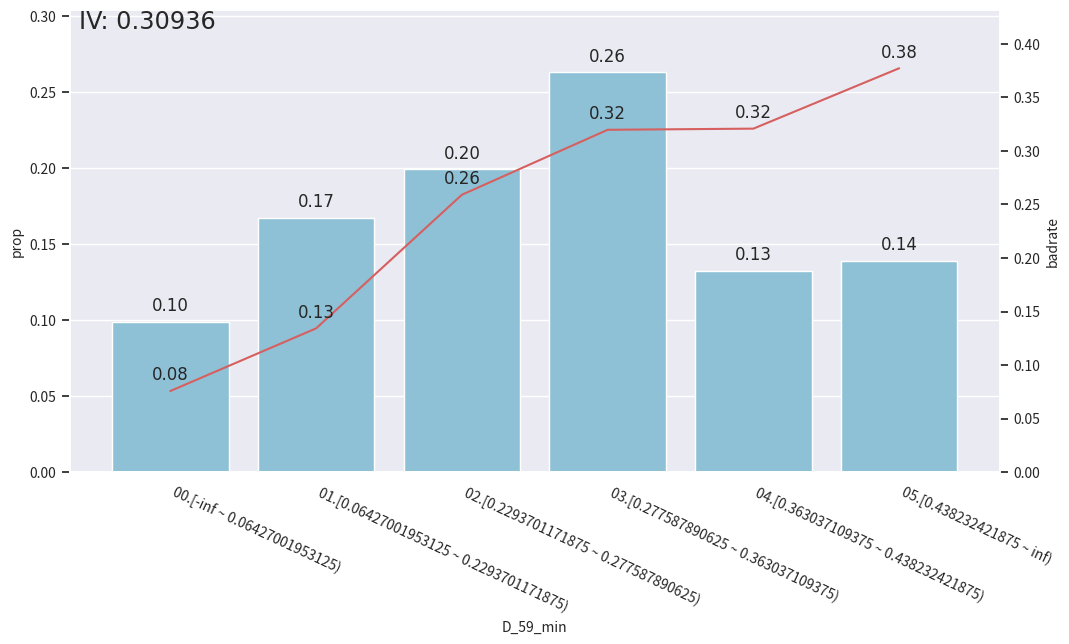

In [51]:
from toad.plot import bin_plot

# 학습 데이터(train_selected)에서 'var_d2' 변수의 bin 결과를 확인합니다.
col = 'D_59_min'

# 시각화를 위해 'labels = True'로 설정하는 것이 좋습니다.
bin_plot(c.transform(train_selected[[col, 'target']], labels=True), x=col, target='target')


> ##### 위 코드는 bin_plot 함수를 사용하여 'R_4_std' 변수의 binning 결과를 시각화하는 부분입니다.

> ##### c.transform(train_selected[[col, 'target']], labels=True): 학습 데이터(train_selected)의 'R_4_std' 변수와 목표 변수('target')를 선택하여 binning 결과를 생성합니다. labels=True로 설정하여 bin의 라벨을 포함한 결과를 반환합니다.

> ##### bin_plot(...): binning 결과를 시각화합니다. x축에는 'R_4_std' 변수의 값이 나타나며, target 변수('target')의 값에 따라 각 bin의 분포를 확인할 수 있습니다. bin_plot 함수를 통해 binning 결과를 시각적으로 확인하여 데이터의 패턴을 파악할 수 있습니다.

<AxesSubplot: xlabel='S_3_last', ylabel='prop'>

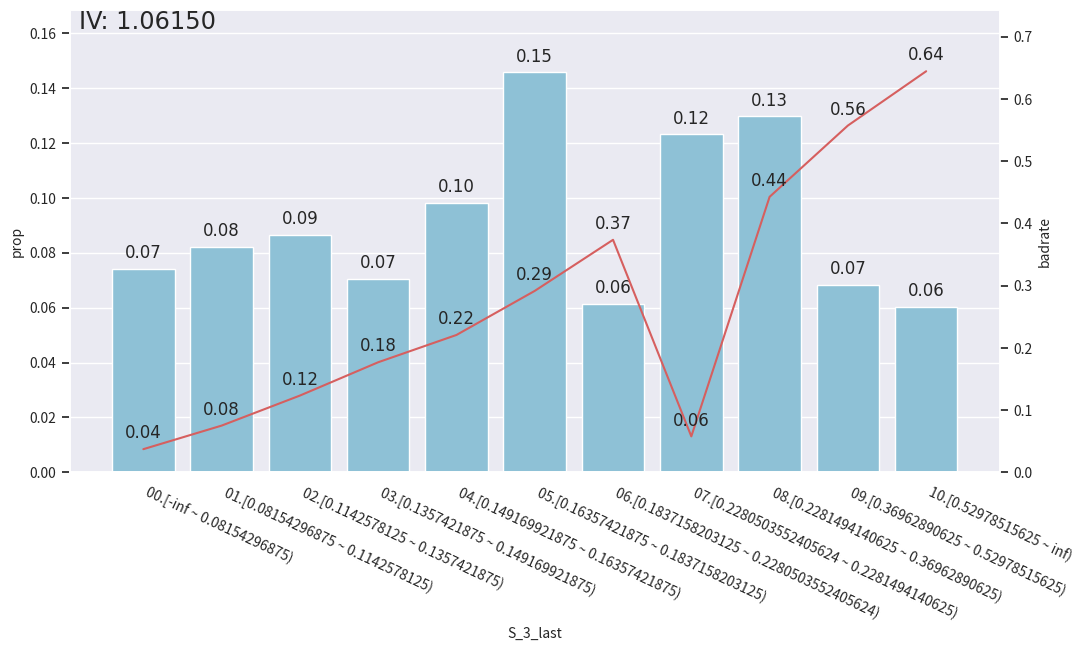

In [52]:
# 학습 데이터(train_selected)에서 'D_51_min' 변수의 bin 결과를 확인합니다.
col = 'S_3_last'

# 범주형 변수의 경우 'labels = True'로 설정하는 것이 좋습니다.
bin_plot(c.transform(train_selected[[col, 'target']], labels=True), x=col, target='target')

Toad의 binning 기능은 범주형 및 수치형 변수를 모두 지원합니다. "toad.transform.Combiner()" 클래스를 사용하여 학습하며, 절차는 다음과 같습니다:

* 초기화(initalise) : c = toad.transform.Combiner()
* *train binning*: c.fit(dataframe, y='target', method='chi', min_samples=None, n_bins=None, empty_separate=False)
* y: 목표 변수;
* method: binning에 적용할 방법. 'chi' (카이제곱), 'dt' (의사결정 트리), 'kmeans' (K-means), 'quantile' (동일한 백분위수 기준), 'step' (동일한 간격)을 지원합니다.
* min_samples: 샘플당 요구되는 최소 수 또는 비율. 각 버킷에 필요한 최소 샘플 수 / 비율입니다.
* n_bins: 최소한의 버킷 수. 수가 너무 큰 경우, 알고리즘은 얻을 수 있는 최대 버킷 수를 반환합니다.
* empty_separate: 누락된 값이 버킷 내에 별도로 분리되는지 여부. False인 경우, 누락된 값은 가장 가까운 나쁜 비율 버킷과 함께 배치됩니다.
* binning 결과: c.export()
* bins 조정: c.update(dict)
* bins 적용 및 이산값으로 변환: c.transform(dataframe, labels=False)
* labels: 데이터를 설명 라벨로 변환할지 여부. False인 경우 0, 1, 2...로 반환됩니다. 범주형 변수는 비율의 내림차순으로 정렬됩니다. True인 경우 (-무한대, 0], (0, 10], (10, 무한대)와 같이 반환됩니다.

* 참고: 1. 불필요한 열을 제외하는 것을 잊지 마세요. 특히 ID 열과 타임스탬프 열은 제외해야 합니다.. 2. 고유 값이 많은 열은 학습에 많은 시간이 소요될 수 있습니다.*

In [53]:
# 초기화
transer = toad.transform.WOETransformer()

# transer.fit_transform() 및 combiner.transform()을 적용합니다. target을 제외하도록 주의하세요.
train_woe = transer.fit_transform(c.transform(train_selected), train_selected['target'], exclude='target')

train_woe.head(3)


,D_59_min,B_14_max,S_20_mean,R_15_std,D_118_min,D_51_min,D_83_min,S_22_min,D_121_min,D_94_last,...,S_3_last,D_51_std,B_30_last,B_38_last,D_114_last,D_117_last,D_120_last,D_64_last,D_68_last,target
0,0.541356,0.811692,0.0,-0.293213,0.030888,0.328601,0.661812,1.137437,0.287478,0.0,...,1.637711,0.263882,-0.469073,1.521713,0.508513,0.192825,0.927761,0.484925,0.110150,1
1,0.292700,0.233572,0.0,-0.293213,-0.005785,0.279585,-0.044543,-0.181886,-0.370781,0.0,...,0.812437,-1.388027,-0.469073,0.394101,0.508513,-0.421929,-0.291743,0.484925,-0.429429,0
2,0.287726,0.335402,0.0,1.523834,0.030888,-1.859642,0.661812,1.137437,0.287478,0.0,...,-0.494801,0.410754,-0.469073,-1.277605,-0.378273,0.371257,0.927761,0.484925,-0.429429,0


* WOETransformer를 초기화합니다.
* combiner.transform()의 결과에 transer.fit_transform()을 적용합니다. 
* target을 제외하도록 주의하세요.
* 변환된 train_woe 데이터프레임의 처음 3개 행을 출력합니다.

In [55]:
col = train_woe.columns.tolist()[:-1]
col.remove('D_117_last')

> #### 예시를 위해 제거했던 변수를 제거해줍니다.

> #### 예시를 위해 간단한 로지스틱 회귀 모델을 적합해봅니다.

In [56]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train_woe[col], train_woe['target'])

# 훈련 데이터와 Out-of-Time (OOT) 데이터에 대해 예측된 확률을 구합니다.
pred_train = lr.predict_proba(train_woe[col])[:,1]

> #### Toad 역시 쉽게 KS 통계량과 AUC를 계산할 수 있는 라이브러리를 제공합니다.

In [57]:
from toad.metrics import KS, AUC

In [58]:
print('train KS',KS(pred_train, train_woe['target']))
print('train AUC',AUC(pred_train, train_woe['target']))

train KS 0.7580537427580776
train AUC 0.9471552269075254


> #### Toad에서도 OptBinning과 마찬가지로 스코어링을 할 수 있는 스코어 카드 기능을 제공합니다.

In [60]:
card = toad.ScoreCard(
    combiner = c,
    transer = transer,
    C=0.1,
    base_score = 600,
    base_odds = 35 ,
    pdo = 60,
    rate = 2
)

card.fit(train_woe[col], train_woe['target'])

ScoreCard(base_score=600,
          combiner=<toad.transform.Combiner object at 0x79db6abb3f70>,
          transer=<toad.transform.WOETransformer object at 0x79db776f8c10>)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>💡 Note!:</font></h3>



* toad.ScoreCard는 Scorecard 모델을 생성하기 위한 클래스입니다.

* combiner는 binning 결과를 담고 있는 toad.transform.Combiner 객체를 전달합니다.

* transer는 WOE 변환을 담당하는 toad.transform.WOETransformer 객체를 전달합니다.

* C는 Logistic Regression에서의 규제 강도를 나타내는 매개변수입니다.

* base_score는 기준 스코어로, 기본적으로 모든 변수의 WOE 값이 0일 때의 스코어입니다.

* base_odds는 기준 오즈로, 기본적으로 모든 변수의 WOE 값이 0일 때의 오즈입니다.

* pdo는 Point to Double the Odds로, 오즈를 두배로 만들기 위해 필요한 점수의 차이입니다.

* rate는 모델의 점수 스케일을 조절하기 위한 비율입니다.

* fit() 메서드를 사용하여 Scorecard 모델을 훈련시킵니다. train_woe[col]은 독립 변수를, train_woe['target']은 종속 변수를 나타냅니다.

In [74]:
sample_train_woe = train_woe.sample(3)
score_sample = card.predict(sample_train_woe[col])
score_sample_rounded = score_sample.round().astype(int)

for i, score in enumerate(score_sample_rounded, start=1):
    print(f"{i}번째 고객의 점수는 \033[1;34m{score}\033[0m점 입니다.")


1번째 고객의 점수는 298점 입니다.
2번째 고객의 점수는 656점 입니다.
3번째 고객의 점수는 394점 입니다.


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>💡 Note:</font></h3>


* 1. `sample_train_woe = train_woe.sample(3)`: `sample()` 함수를 사용하여 `train_woe` 데이터셋에서 임의로 3개의 샘플을 추출합니다. 이 샘플들은 점수를 계산할 데이터입니다.

* 2. `score_sample = card.predict(sample_train_woe[col])`: `card` 라는 ScoreCard 객체의 `predict()` 메서드를 사용하여 위에서 추출한 샘플에 대한 점수를 계산합니다. 이 때, `sample_train_woe[col]`을 통해 샘플의 해당 컬럼(변수)만 사용하게 됩니다.

* 3. `score_sample_rounded = score_sample.round().astype(int)`: 계산된 점수는 일반적으로 소수점 형태로 반환됩니다. 이 줄의 코드는 `round()` 함수를 사용하여 계산된 점수를 반올림하고, `astype(int)`를 통해 정수형으로 변환합니다.

* 4. `for i, score in enumerate(score_sample_rounded, start=1)`: 이 줄은 반복문을 사용하여 각 샘플에 대한 점수를 순서대로 출력합니다. `enumerate()` 함수는 반복 가능한 객체(여기서는 `score_sample_rounded`)를 입력으로 받아 인덱스 번호(i)와 그에 해당하는 값을(score) 함께 반환합니다. `start=1`은 인덱스 번호가 1부터 시작하도록 설정합니다.

* 5. `print(f"{i}번째 고객의 점수는 \033[1;34m{score}\033[0m점 입니다.")`: 이 줄은 문자열 포매팅을 사용하여 각 샘플에 대한 점수를 보기 좋게 출력합니다. `\033[1;34m`와 `\033[0m` 사이에 있는 텍스트는 파란색으로 출력됩니다.

In [66]:
card.export()

{'D_59_min': {'[-inf ~ 0.06427001953125)': 18.13,
  '[0.06427001953125 ~ 0.2293701171875)': 13.13,
  '[0.2293701171875 ~ 0.277587890625)': 6.75,
  '[0.277587890625 ~ 0.363037109375)': 4.43,
  '[0.363037109375 ~ 0.438232421875)': 4.39,
  '[0.438232421875 ~ inf)': 2.44},
 'B_14_max': {'[-inf ~ 0.01009368896484375)': -5.95,
  '[0.01009368896484375 ~ 0.0266265869140625)': 2.39,
  '[0.0266265869140625 ~ 0.03668212890625)': 11.48,
  '[0.03668212890625 ~ 0.060089111328125)': 8.67,
  '[0.060089111328125 ~ inf)': 8.06},
 'R_15_std': {'[-inf ~ 0.003902495102107255)': 6.76,
  '[0.003902495102107255 ~ inf)': 6.29},
 'D_118_min': {'[-inf ~ 0.0034770965576171875)': 4.55,
  '[0.0034770965576171875 ~ 0.00777435302734375)': -0.35,
  '[0.00777435302734375 ~ 0.06329345703125)': -2.66,
  '[0.06329345703125 ~ 0.1373291015625)': 1.66,
  '[0.1373291015625 ~ 0.22956451324668045)': 6.8,
  '[0.22956451324668045 ~ 0.274169921875)': 6.07,
  '[0.274169921875 ~ 0.345947265625)': 11.29,
  '[0.345947265625 ~ 0.425781

> ##### card.export()는 훈련된 Scorecard 모델의 정보를 추출하는 메서드입니다. 이 메서드를 호출하면 다음과 같은 정보를 포함하는 딕셔너리를 반환합니다:

> 'model_info': Scorecard 모델의 기본 정보를 담고 있는 딕셔너리입니다. 여기에는 C, base_score, base_odds, pdo, rate 등의 모델 설정값이 포함됩니다.

> 'features': Scorecard 모델에 사용된 독립 변수의 정보를 담고 있는 딕셔너리입니다. 각 변수마다 변수명, WOE 정보, 점수 정보 등이 포함됩니다.
이를 통해 훈련된 Scorecard 모델의 설정값과 각 변수의 정보를 확인할 수 있습니다.